# Modèle linéaire de prédiction

### Librairies

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from datetime import datetime

from lib.dataeng import Etl

import seaborn as sns

### Sourcing Data

In [2]:
etl = Etl()

df_weight_raw, df_food_raw, df_exos_raw, df_all = etl.extract_store_all()


Le fichier poids le plus récent est : data_BEN_1708930745.zip, parmi :
data_BEN_1708497738.zip
data_BEN_1708580428.zip
data_BEN_1708763698.zip
data_BEN_1708405395.zip
data_BEN_1708327447.zip
data_BEN_1708674104.zip
data_BEN_1708234834.zip
data_BEN_1708930745.zip
data_BEN_1708837497.zip

Le fichier food le plus récent est : File-Export-2020-08-03-to-2024-02-26.zip, parmi
File-Export-2020-08-03-to-2024-02-21.zip
File-Export-2020-08-03-to-2024-02-26.zip
File-Export-2020-08-03-to-2024-02-24.zip
File-Export-2020-08-03-to-2024-02-18.zip
File-Export-2020-08-03-to-2024-02-25.zip
File-Export-2020-08-03-to-2024-02-19.zip
File-Export-2020-08-03-to-2024-02-20.zip
File-Export-2020-08-03-to-2024-02-23.zip
File-Export-2020-08-03-to-2024-02-22.zip

Le fichier exercices le plus récent est : polar-user-data-export_bd8a06c1-7cac-47fc-a1fe-71b374e61732.zip, parmi :
polar-user-data-export_bd8a06c1-7cac-47fc-a1fe-71b374e61732.zip
polar-user-data-export_12baa4ce-79a5-40f8-ad40-74308f7c2c26.zip
polar-user-da

100%|██████████| 1924/1924 [00:50<00:00, 38.39it/s]


## Constitution Dataset

### Poids

In [3]:
df_weight_raw

,Date,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
0,2024-02-26,72.72,12.34,3.02,57.35,40.42,0.169692,1674.208
1,2024-02-26,72.50,12.27,3.01,57.20,40.28,0.169241,1670.968
2,2024-02-26,72.70,12.33,3.02,57.34,40.42,0.169601,1673.992
3,2024-02-26,72.68,12.37,3.01,57.29,40.35,0.170198,1672.696
4,2024-02-26,72.65,12.37,3.01,57.25,40.32,0.170268,1672.048
...,...,...,...,...,...,...,...,...
9348,2020-08-14,104.50,33.85,NaN,NaN,NaN,0.323923,1896.040
9349,2020-08-13,104.40,34.34,NaN,NaN,NaN,0.328927,1883.296
9350,2020-08-12,104.35,33.80,NaN,NaN,NaN,0.323910,1893.880
9351,2020-08-11,104.65,33.15,NaN,NaN,NaN,0.316770,1914.400


In [4]:
df_weight = df_weight_raw.groupby('Date').mean()  # récupère les valeurs quotidiennes moyennes

std_empiriques = df_weight_raw.groupby('Date').std().dropna()  # calcule les ecarts-types empiriques

In [5]:
df_weight_raw.groupby('Date').std().describe(include='all')

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
count,1251.000000,1251.000000,358.000000,358.000000,358.000000,1251.000000,1251.000000
mean,0.070389,0.086666,0.004776,0.068206,0.076268,0.001065,1.728270
std,0.046426,0.077278,0.003649,0.040117,0.058265,0.000783,1.669350
min,0.000000,0.000000,0.000000,0.009910,0.013887,0.000054,0.000000
25%,0.038188,0.054772,0.003780,0.052628,0.056327,0.000717,1.108426
50%,0.057009,0.074646,0.004880,0.066332,0.071525,0.000962,1.444737
75%,0.094763,0.096274,0.005345,0.079159,0.086713,0.001213,1.865441
max,0.588509,1.139576,0.063631,0.716210,1.072184,0.011172,24.415008


In [6]:
std_empiriques

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-03-04,0.036148,0.058992,0.004082,0.056716,0.066533,0.000812,1.264415
2023-03-05,0.092376,0.106369,0.000000,0.037353,0.053229,0.001281,0.821828
2023-03-06,0.023452,0.030496,0.000000,0.031937,0.040988,0.000427,0.787734
2023-03-07,0.018708,0.050067,0.000000,0.052026,0.072019,0.000706,1.255156
2023-03-08,0.042269,0.052313,0.004082,0.038297,0.064317,0.000674,0.893206
...,...,...,...,...,...,...,...
2024-02-22,0.133752,0.100524,0.006292,0.082785,0.081973,0.001165,1.901076
2024-02-23,0.157138,0.114143,0.004577,0.064054,0.057180,0.001229,1.447745
2024-02-24,0.148654,0.106480,0.005345,0.085496,0.083106,0.001207,1.886345


In [14]:
std_empiriques.describe(include='all')

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,0.102342,0.085907,0.004776,0.068206,0.076268,0.001031,1.560277
std,0.057216,0.028602,0.003649,0.040117,0.058265,0.000341,0.935483
min,0.011127,0.021931,0.000000,0.009910,0.013887,0.000292,0.282810
25%,0.047117,0.064215,0.003780,0.052628,0.056327,0.000796,1.187737
50%,0.111860,0.086046,0.004880,0.066332,0.071525,0.001021,1.524753
75%,0.136564,0.104457,0.005345,0.079159,0.086713,0.001229,1.802853
max,0.588509,0.195337,0.063631,0.716210,1.072184,0.003612,16.816833


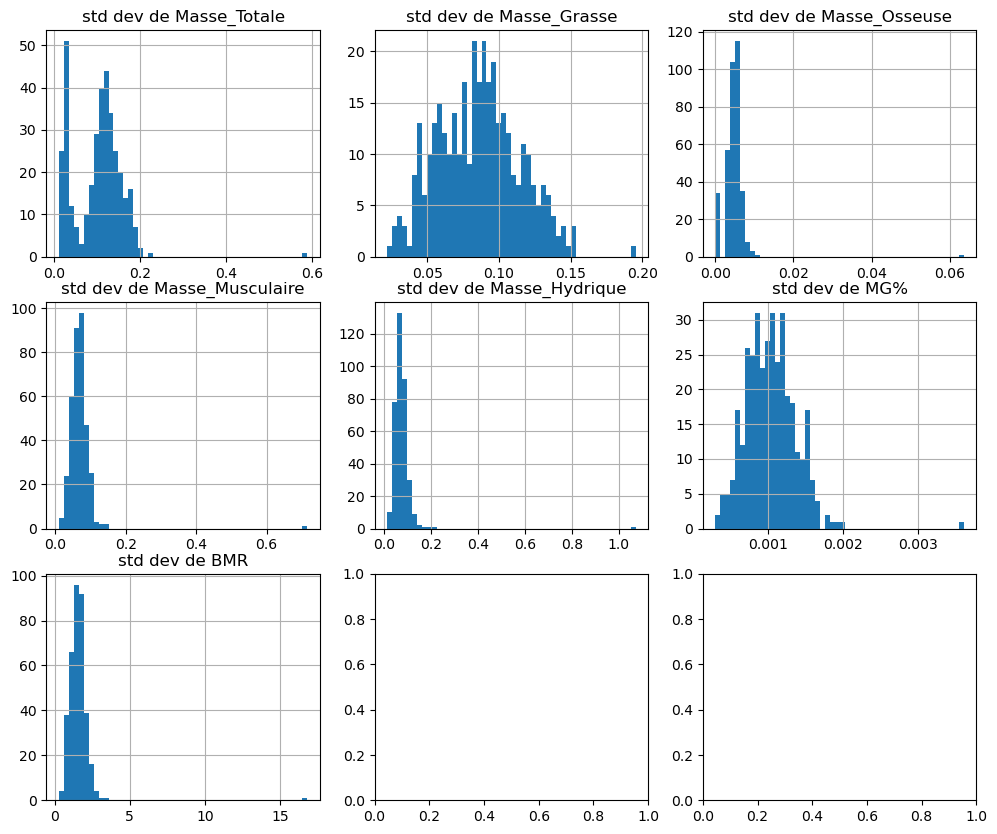

In [35]:
fig, axs = plt.subplots(nrows=len(std_empiriques.columns)//3+1, ncols=3, figsize=(12,10))
NBINS = 50

for i, name in enumerate(std_empiriques.columns):
    r = i//3
    c = i%3
    x = std_empiriques[name].to_numpy()
    axs[r,c].hist(x, bins=NBINS)
    axs[r,c].set_title(f'std dev de {name}')
    axs[r,c].grid(True)

plt.show()

In [36]:
df_weight

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2020-08-09,107.250000,37.190000,NaN,NaN,NaN,0.346760,1883.2960
2020-08-11,104.650000,33.150000,NaN,NaN,NaN,0.316770,1914.4000
2020-08-12,104.350000,33.800000,NaN,NaN,NaN,0.323910,1893.8800
2020-08-13,104.400000,34.340000,NaN,NaN,NaN,0.328927,1883.2960
2020-08-14,104.500000,33.850000,NaN,NaN,NaN,0.323923,1896.0400
...,...,...,...,...,...,...,...
2024-02-22,72.546875,12.591250,2.994375,56.945000,39.985625,0.173559,1665.0415
2024-02-23,72.727333,12.710000,2.997333,57.002000,40.025333,0.174760,1666.3744
2024-02-24,72.105333,12.296667,2.990000,56.803333,39.890667,0.170536,1661.8672


### Food

In [37]:
df_food_raw

,Date,Meal,Calories,Lipides,Glucides,Proteines
0,2020-08-03,Breakfast,621.4,27.9,69.7,22.4
1,2020-08-03,Dinner,581.6,20.4,84.5,17.1
2,2020-08-03,Lunch,656.0,41.4,26.6,33.5
3,2020-08-03,Snacks,58.0,0.0,14.0,0.0
4,2020-08-04,Breakfast,1111.6,49.0,137.8,34.3
...,...,...,...,...,...,...
3781,2024-02-24,Dinner,398.8,12.1,40.8,31.1
3782,2024-02-24,Lunch,1184.1,18.4,177.3,85.5
3783,2024-02-25,Breakfast,606.0,16.2,23.0,88.3
3784,2024-02-25,Dinner,627.4,30.1,73.2,20.5


In [38]:
df_food = df_food_raw.set_index(['Date','Meal']).unstack('Meal')

In [39]:
df_food.fillna(0, inplace=True)

In [40]:
df_food.columns = df_food.columns.to_flat_index()

In [41]:
new_names = [ name[0] + '_' + name[1] for name in df_food.columns ]
df_food.columns = new_names

In [42]:
df_food.head(10)

,Calories_Breakfast,Calories_Dinner,Calories_Lunch,Calories_Snacks,Lipides_Breakfast,Lipides_Dinner,Lipides_Lunch,Lipides_Snacks,Glucides_Breakfast,Glucides_Dinner,Glucides_Lunch,Glucides_Snacks,Proteines_Breakfast,Proteines_Dinner,Proteines_Lunch,Proteines_Snacks
Date,,,,,,,,,,,,,,,,
2020-08-03,621.4,581.6,656.0,58.0,27.9,20.4,41.4,0.0,69.7,84.5,26.6,14.0,22.4,17.1,33.5,0.0
2020-08-04,1111.6,447.4,433.7,0.0,49.0,2.1,16.6,0.0,137.8,69.1,60.6,0.0,34.3,28.5,15.6,0.0
2020-08-05,1174.2,136.7,638.0,0.0,51.6,6.7,25.8,0.0,147.1,3.2,62.8,0.0,35.7,14.8,36.4,0.0
2020-08-06,747.0,801.3,388.9,0.0,35.3,15.5,15.6,0.0,81.4,22.6,30.3,0.0,25.8,11.8,22.4,0.0
2020-08-07,791.9,397.5,484.6,0.0,35.5,7.2,24.8,0.0,91.6,75.4,1.9,0.0,27.3,7.9,60.0,0.0
2020-08-08,714.5,359.8,499.3,383.1,29.8,19.8,22.7,19.3,85.6,3.4,38.5,1.6,26.4,40.0,26.7,14.7
2020-08-09,683.1,504.7,615.5,58.0,25.0,30.8,15.5,0.0,88.3,51.2,91.5,14.0,26.7,10.6,28.8,0.0
2020-08-10,646.8,604.6,214.0,0.0,21.0,10.0,11.8,0.0,88.3,107.8,11.1,0.0,26.7,20.7,14.9,0.0
2020-08-11,557.5,413.1,801.8,0.0,12.9,21.3,16.3,0.0,83.2,43.4,59.2,0.0,26.8,10.3,67.0,0.0


### Exercices

In [43]:
df_exos_raw

,exo_duree,exo_type,exo_cals_bruts
exo_date,,,
2021-03-29,3220.826,STRENGTH_TRAINING,328.0
2021-03-30,2818.678,RUNNING,449.0
2021-03-31,3186.236,STRENGTH_TRAINING,272.0
2021-04-01,0.000,0,0.0
2021-04-02,0.000,0,0.0
...,...,...,...
2024-02-22,3066.733,STRENGTH_TRAINING,373.0
2024-02-22,2381.453,WALKING,288.0
2024-02-23,2444.829,STRENGTH_TRAINING,233.0


In [44]:
df_exos_raw['exo_type'].value_counts()

STRENGTH_TRAINING       517
INDOOR_ROWING           325
0                       268
WALKING                 160
RUNNING                  22
JOGGING                  21
CROSS-COUNTRY_SKIING      6
BOXING                    4
DOWNHILL_SKIING           2
ROWING                    1
SWIMMING                  1
TREADMILL_RUNNING         1
Name: exo_type, dtype: int64

In [45]:
mask = df_exos_raw['exo_type']==0

df_exos_raw = df_exos_raw[~mask]

# df_exos_raw.describe(include='all')

# df_exos_raw

In [46]:
df_exos = df_exos_raw.groupby(['exo_date', 'exo_type']).sum()

In [47]:
df_exos = df_exos.unstack('exo_type')

In [48]:
df_exos.fillna(0, inplace=True)

In [49]:
df_exos.columns = df_exos.columns.to_flat_index()

In [50]:
new_names = [ name[1] + '_' + name[0] for name in df_exos.columns ]
df_exos.columns = new_names

In [52]:
df_exos

,BOXING_exo_duree,CROSS-COUNTRY_SKIING_exo_duree,DOWNHILL_SKIING_exo_duree,INDOOR_ROWING_exo_duree,JOGGING_exo_duree,ROWING_exo_duree,RUNNING_exo_duree,STRENGTH_TRAINING_exo_duree,SWIMMING_exo_duree,TREADMILL_RUNNING_exo_duree,...,CROSS-COUNTRY_SKIING_exo_cals_bruts,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts
exo_date,,,,,,,,,,,,,,,,,,,,,
2021-03-29,0.0,0.0,0.0,0.0,0.000,0.0,0.000,3220.826,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,328.0,0.0,0.0,0.0
2021-03-30,0.0,0.0,0.0,0.0,0.000,0.0,2818.678,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,449.0,0.0,0.0,0.0,0.0
2021-03-31,0.0,0.0,0.0,0.0,0.000,0.0,0.000,3186.236,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,272.0,0.0,0.0,0.0
2021-04-03,0.0,0.0,0.0,0.0,0.000,0.0,0.000,3436.335,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,344.0,0.0,0.0,0.0
2021-04-04,0.0,0.0,0.0,0.0,2682.132,0.0,0.000,0.000,0.0,0.0,...,0.0,0.0,0.0,494.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-21,0.0,0.0,0.0,0.0,0.000,0.0,0.000,3490.972,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,361.0,0.0,0.0,0.0
2024-02-22,0.0,0.0,0.0,0.0,0.000,0.0,0.000,3066.733,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,373.0,0.0,0.0,288.0
2024-02-23,0.0,0.0,0.0,0.0,0.000,0.0,0.000,2444.829,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,0.0,0.0


### Dataframe complète

In [53]:
df_all = pd.concat([df_weight, df_food, df_exos], axis=1).sort_index()

In [54]:
df_all.dropna(subset=['Masse_Totale', 'Masse_Grasse'], inplace=True)
df_all['Calories_Total'] = df_all['Calories_Breakfast'] + df_all['Calories_Dinner'] + df_all['Calories_Lunch'] + df_all['Calories_Snacks']
df_all

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories_Breakfast,Calories_Dinner,Calories_Lunch,...,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts,Calories_Total
2020-08-09,107.250000,37.190000,NaN,NaN,NaN,0.346760,1883.2960,683.1,504.7,615.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1861.3
2020-08-11,104.650000,33.150000,NaN,NaN,NaN,0.316770,1914.4000,557.5,413.1,801.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1772.4
2020-08-12,104.350000,33.800000,NaN,NaN,NaN,0.323910,1893.8800,690.1,563.3,640.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1894.3
2020-08-13,104.400000,34.340000,NaN,NaN,NaN,0.328927,1883.2960,723.0,541.3,558.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1822.6
2020-08-14,104.500000,33.850000,NaN,NaN,NaN,0.323923,1896.0400,723.0,637.9,530.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1891.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,72.546875,12.591250,2.994375,56.945000,39.985625,0.173559,1665.0415,673.5,342.1,729.5,...,0.0,0.0,0.0,0.0,0.0,373.0,0.0,0.0,288.0,1745.1
2024-02-23,72.727333,12.710000,2.997333,57.002000,40.025333,0.174760,1666.3744,560.1,532.6,646.9,...,0.0,0.0,0.0,0.0,0.0,233.0,0.0,0.0,0.0,1739.6
2024-02-24,72.105333,12.296667,2.990000,56.803333,39.890667,0.170536,1661.8672,442.7,398.8,1184.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.0,2025.6
2024-02-25,73.082000,12.451333,3.029333,57.584667,40.636000,0.170373,1679.6224,606.0,627.4,734.7,...,0.0,0.0,0.0,0.0,0.0,649.0,0.0,0.0,0.0,1968.1


### Construction d'une dataframe avec toutes les masses renseignées (ie depuis Mars 2023)

In [56]:
# df_all_masses est la Dataframe avec toutes les masses non NaN (depuis 2023)

df_all_masses = df_all.dropna(subset=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique'])  # drop les lignes où les masses Osseuse, Musculaire ou Hydrique sont NaN
df_all_masses.fillna(0, inplace=True)  # Met 0 dans les données d'exercice NaN
df_all_masses

/tmp/ipykernel_10624/2000915907.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_masses.fillna(0, inplace=True)  # Met 0 dans les données d'exercice NaN


,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories_Breakfast,Calories_Dinner,Calories_Lunch,...,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts,Calories_Total
2023-03-04,70.656667,11.420000,2.961667,56.258333,39.496667,0.161627,1649.512000,0.0,1329.2,941.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2271.1
2023-03-05,71.880000,11.848571,3.000000,57.014286,40.180000,0.164837,1666.678857,0.0,644.9,1129.4,...,0.0,0.0,0.0,0.0,0.0,443.0,0.0,0.0,0.0,1774.3
2023-03-06,71.030000,10.924000,3.010000,57.082000,40.476000,0.153794,1668.289600,0.0,968.1,791.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,614.0,1759.7
2023-03-07,72.185000,11.126667,3.060000,57.986667,41.366667,0.154141,1688.860000,968.5,1212.3,335.6,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,0.0,1016.0,2516.4
2023-03-08,72.283333,10.178333,3.131667,58.956667,42.821667,0.140811,1711.468000,986.9,0.0,672.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,1658.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,72.546875,12.591250,2.994375,56.945000,39.985625,0.173559,1665.041500,673.5,342.1,729.5,...,0.0,0.0,0.0,0.0,0.0,373.0,0.0,0.0,288.0,1745.1
2024-02-23,72.727333,12.710000,2.997333,57.002000,40.025333,0.174760,1666.374400,560.1,532.6,646.9,...,0.0,0.0,0.0,0.0,0.0,233.0,0.0,0.0,0.0,1739.6
2024-02-24,72.105333,12.296667,2.990000,56.803333,39.890667,0.170536,1661.867200,442.7,398.8,1184.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.0,2025.6
2024-02-25,73.082000,12.451333,3.029333,57.584667,40.636000,0.170373,1679.622400,606.0,627.4,734.7,...,0.0,0.0,0.0,0.0,0.0,649.0,0.0,0.0,0.0,1968.1


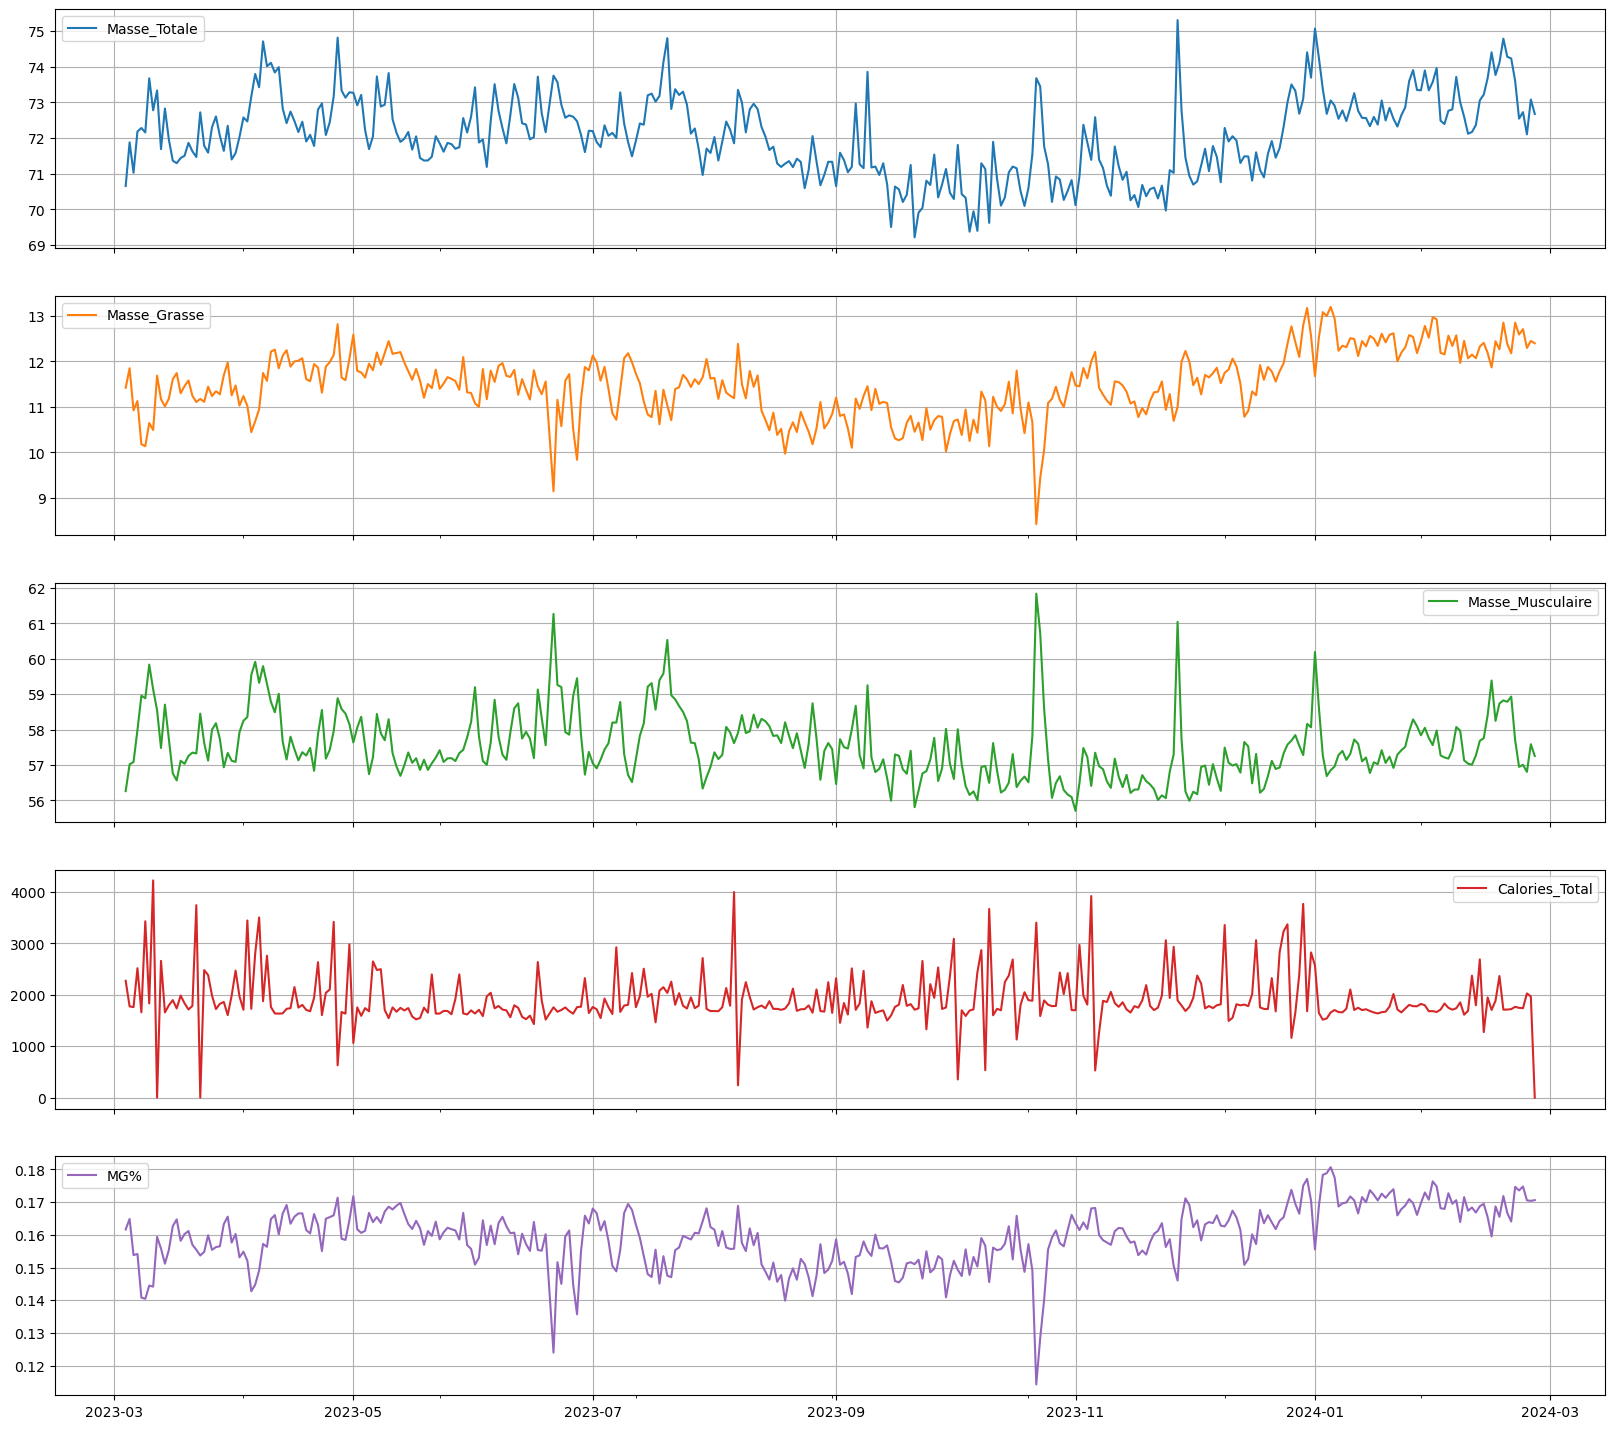

In [64]:
cols_to_display = ['Masse_Totale', 'Masse_Grasse', 'Masse_Musculaire', 'Calories_Total', 'MG%']

df_all_masses[cols_to_display].plot(subplots=True, figsize=(20,18), grid=True)
plt.show()

### Construction d'une autre dataframe avec juste masse totale et masse grasse (depuis Septembre 2020)

In [58]:
# df_mtmg_only est la dataframe avec les masses Totale et Grasse (depuis 2020)

df_mtmg_only = df_all.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique'])

In [59]:
df_mtmg_only.fillna(0, inplace=True)

In [60]:
# df_mtmg_only.dropna(inplace=True)
df_mtmg_only

,Masse_Totale,Masse_Grasse,MG%,BMR,Calories_Breakfast,Calories_Dinner,Calories_Lunch,Calories_Snacks,Lipides_Breakfast,Lipides_Dinner,...,DOWNHILL_SKIING_exo_cals_bruts,INDOOR_ROWING_exo_cals_bruts,JOGGING_exo_cals_bruts,ROWING_exo_cals_bruts,RUNNING_exo_cals_bruts,STRENGTH_TRAINING_exo_cals_bruts,SWIMMING_exo_cals_bruts,TREADMILL_RUNNING_exo_cals_bruts,WALKING_exo_cals_bruts,Calories_Total
2020-08-09,107.250000,37.190000,0.346760,1883.2960,683.1,504.7,615.5,58.0,25.0,30.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1861.3
2020-08-11,104.650000,33.150000,0.316770,1914.4000,557.5,413.1,801.8,0.0,12.9,21.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1772.4
2020-08-12,104.350000,33.800000,0.323910,1893.8800,690.1,563.3,640.9,0.0,25.0,13.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1894.3
2020-08-13,104.400000,34.340000,0.328927,1883.2960,723.0,541.3,558.3,0.0,29.0,19.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1822.6
2020-08-14,104.500000,33.850000,0.323923,1896.0400,723.0,637.9,530.6,0.0,29.0,27.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1891.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,72.546875,12.591250,0.173559,1665.0415,673.5,342.1,729.5,0.0,10.5,5.8,...,0.0,0.0,0.0,0.0,0.0,373.0,0.0,0.0,288.0,1745.1
2024-02-23,72.727333,12.710000,0.174760,1666.3744,560.1,532.6,646.9,0.0,13.6,21.8,...,0.0,0.0,0.0,0.0,0.0,233.0,0.0,0.0,0.0,1739.6
2024-02-24,72.105333,12.296667,0.170536,1661.8672,442.7,398.8,1184.1,0.0,7.8,12.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.0,2025.6
2024-02-25,73.082000,12.451333,0.170373,1679.6224,606.0,627.4,734.7,0.0,16.2,30.1,...,0.0,0.0,0.0,0.0,0.0,649.0,0.0,0.0,0.0,1968.1


In [61]:
df_mtmg_only.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1280 entries, 2020-08-09 to 2024-02-26
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Masse_Totale                         1280 non-null   float64
 1   Masse_Grasse                         1280 non-null   float64
 2   MG%                                  1280 non-null   float64
 3   BMR                                  1280 non-null   float64
 4   Calories_Breakfast                   1280 non-null   float64
 5   Calories_Dinner                      1280 non-null   float64
 6   Calories_Lunch                       1280 non-null   float64
 7   Calories_Snacks                      1280 non-null   float64
 8   Lipides_Breakfast                    1280 non-null   float64
 9   Lipides_Dinner                       1280 non-null   float64
 10  Lipides_Lunch                        1280 non-null   float64
 11  Lipides_Snacks      

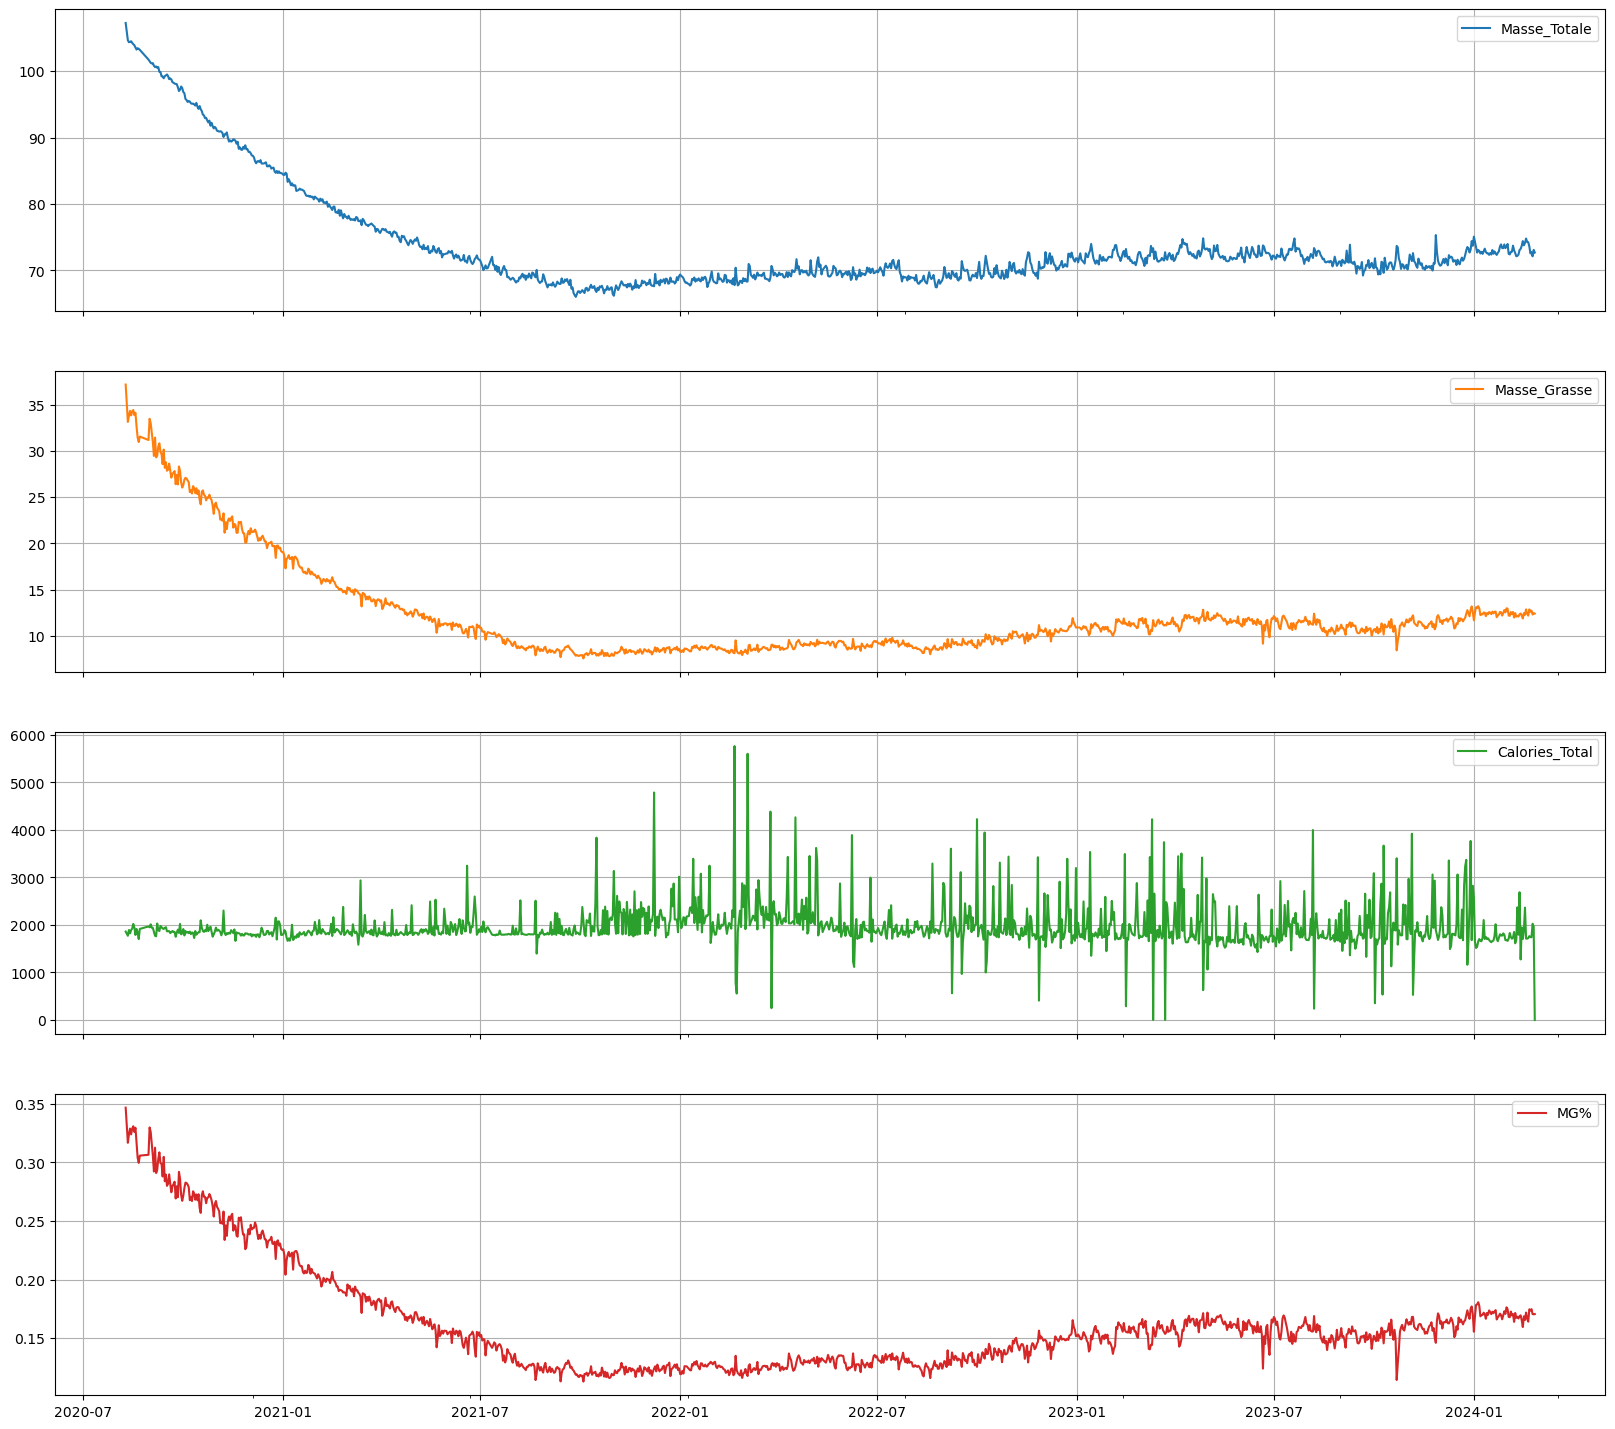

In [63]:
cols_to_display = ['Masse_Totale', 'Masse_Grasse', 'Calories_Total', 'MG%']

df_mtmg_only[cols_to_display].plot(subplots=True, figsize=(20,18), grid=True)
plt.show()